In [ ]:
!unzip -q /content/drive/MyDrive/ML/Masters/encoded_data.zip
# !mv -v data* screens
# !unzip -q /content/drive/MyDrive/ML/Masters/UI.zip
# !zip -r /content/drive/MyDrive/ML/Masters/encoded_data.zip /content/data

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install lorem-text
!pip install datasets transformers rouge-score
clear_output()

In [ ]:
import torch
import torchvision
import torch.nn                 as nn
import torch.nn.functional      as F
import torch.optim              as optim
import torchvision.transforms   as transforms
import matplotlib.pyplot        as plt
import matplotlib.cm            as cm
import numpy                    as np
import pandas                   as pd
import multiprocessing          as mp
0
import datasets
import importlib
import skimage
import h5py
import json
import glob
import os
import re

from torch.utils.data           import Dataset
from torch.nn.utils.rnn         import pack_padded_sequence
from torchvision.models         import ResNet101_Weights, resnet101
from imageio                    import imread
from PIL                        import Image
from skimage.transform          import resize
from tqdm                       import tqdm
from collections                import Counter
from random                     import seed, choice, sample
from ast                        import literal_eval
from torch.utils.data           import Dataset, DataLoader, random_split
from transformers               import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers               import VisionEncoderDecoderModel, ViTFeatureExtractor
from transformers               import AutoTokenizer, GPT2Config, default_data_collator
from tokenizers                 import Tokenizer
from tokenizers.models          import WordLevel
from tokenizers.pre_tokenizers  import WhitespaceSplit
from tokenizers                 import pre_tokenizers
from IPython.core.display       import display, HTML
from lorem_text                 import lorem
from html.parser                import HTMLParser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def create_input_files(
        data_folder, 
        output_folder
    ):

    def read_data_paths():
        sketch_paths  = glob.glob(data_folder + "/*.sketch.png")
        ui_paths  = glob.glob(data_folder + "/*.ui.png")
        code_paths    = glob.glob(data_folder + "/*.code.txt")

        sketch_paths.sort()
        ui_paths.sort()
        code_paths.sort()

        return sketch_paths, ui_paths, code_paths
   
    def create_line_indexes(df):
        list_all_line = []
        
        for i, path in enumerate(df['code_paths']):
            with open(path, 'r') as file:
                text = file.read().split()
                list_all_line.extend(text)
                file.close()

        line_to_index = {}
        index_to_line = {}
        for count, item in enumerate(np.unique(list_all_line)):
            line_to_index[item] = count + 1
        
        line_to_index['<start>'] = len(line_to_index) + 1
        line_to_index['<end>']   = len(line_to_index) + 1
        line_to_index['<pad>']   = 0

        index_to_line =  {v:k for k, v in line_to_index.items()}

        return line_to_index, index_to_line
    
    def write_indexes_to_json(indexes):
        with open(output_folder + '/line_to_index.json', 'w') as fr:
            json.dump(indexes[0], fr)

        with open(output_folder + '/index_to_line.json', 'w') as fs:
            json.dump(indexes[1], fs)
    
    def write_tokens_to_json(tokens, padded_tokens, name):      
        with open("{0}/{1}_token_lengths.json".format(output_folder, name), 'w') as fr:
            json.dump([len(t) for t in tokens], fr)
        
        with open("{0}/{1}_tokens.json".format(output_folder, name), 'w') as fr:
            json.dump(padded_tokens, fr)

    def create_tokens(df, line_to_index):
        list_tokenize_line = []
        for i, path in enumerate(df['code_paths']):
            with open(path, 'r') as file:
                text = file.read().split()
                list_tokenize_line.append(list(map(lambda x: line_to_index[x], text)))
                file.close()
            
        return list_tokenize_line
    
    def pad_tokens(tokens, l2i, max_length):
        padded_tokens = []
        
        for i, s in enumerate(tokens):
            padded_tokens.append([l2i['<start>']] + [token for token in s] + [l2i['<end>']] + [l2i['<pad>']] * (max_length - len(s)))
        
        return padded_tokens

    def write_images_to_hdf5(df, name):
        with h5py.File("{0}/{1}_images.hdf5".format(output_folder, name), 'w') as h:
            images = h.create_dataset('images', (len(df['screen_paths']), 3, 256, 256), dtype='uint8')
            size = (256, 256)

            for i, path in tqdm(enumerate(df['screen_paths'])):
                image = imread(path)
                image = np.array(Image.fromarray(image).resize(size, Image.BICUBIC))[:, :, :3]
                image = image.transpose(2, 0, 1)
                images[i] = image

    data        = read_data_paths()
    df1         = pd.DataFrame({'screen_paths': data[0], 'code_paths': data[2]})
    df2         = pd.DataFrame({'screen_paths': data[1], 'code_paths': data[2]})
    df          = df1.append(df2, ignore_index = True)
    indexes     = create_line_indexes(df)
    tokens      = create_tokens(df, indexes[0])
    max_length  = max(len(x) for x in tokens)
    p_tokens    = pad_tokens(tokens, indexes[0], max_length)

    split = int(len(df) * 0.9)
    write_indexes_to_json(indexes)
    write_tokens_to_json(tokens[:split], p_tokens[:split], 'train')
    write_tokens_to_json(tokens[split:], p_tokens[split:], 'val')
    write_images_to_hdf5(df[:split], 'train')
    write_images_to_hdf5(df[split:], 'val')

# create_input_files('screens', 'data')

In [ ]:
class S2CDataset(Dataset):
    def __init__(self, data_folder, split, transform=None):

        self.split  = split
        self.h          = h5py.File('{0}/{1}_images.hdf5'.format(data_folder, split), 'r')
        self.imgs       = self.h['images']
        self.transform  = transform

        with open('{0}/{1}_tokens.json'.format(data_folder, split), 'r') as j:
            self.captions = json.load(j)

        with open('{0}/{1}_token_lengths.json'.format(data_folder, split), 'r') as j:
            self.caplens = json.load(j)

        self.dataset_size = len(self.captions)

    def __getitem__(self, i):
        img_original = torch.IntTensor(self.imgs[i])
        img = torch.FloatTensor(self.imgs[i] / 255.)

        if self.transform is not None:
            img = self.transform(img)

        caption = torch.LongTensor(self.captions[i])
        caplen  = torch.LongTensor([self.caplens[i]])

        return img, caption, caplen, img_original

    def __len__(self):
        return self.dataset_size


In [ ]:
class S2CEncoder(nn.Module):
    def __init__(self, encoded_image_size = 14):
        super(S2CEncoder, self).__init__()
        resnet          = resnet101(weights = ResNet101_Weights.DEFAULT);
        all_modules     = list(resnet.children())
        modules         = all_modules[:-2]
        self.resnet     = nn.Sequential(*modules)
        self.avgpool    = nn.AdaptiveAvgPool2d((encoded_image_size,encoded_image_size))
        self.fine_tune(False)

    def fine_tune(self, fine_tune = False):
        for p in self.resnet.parameters():
            p.requires_grad = fine_tune

    def forward(self, images):
        """
        images -> (batch_size, 3, 256, 256)
        """
        batch_size      = images.size(0)
        encoded_image   = self.resnet(images)                   # (batch_size, 2048, 8, 8)        
        encoded_image   = self.avgpool(encoded_image)           # (batch_size, 2048, 14, 14)
        encoded_image   = encoded_image.permute(0, 2, 3, 1)     # (batch_size, 14, 14, 2048)

        return encoded_image

In [ ]:
class S2CAttention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super(S2CAttention,self).__init__()
    """
    encoder_dim     -> 2048
    decoder_dim     -> 256
    attention_dim   -> 256
    """

    self.encoder_att    = nn.Linear(encoder_dim, attention_dim) # (2048, 256)
    self.decoder_att    = nn.Linear(decoder_dim, attention_dim) # (256, 256)
    self.full_att       = nn.Linear(attention_dim, 1)           # (256, 1)
    self.relu           = nn.ReLU()
    self.softmax        = nn.Softmax(dim = 1)

  def forward(self, encoder_out, decoder_hidden):
    """
    encoder_out     -> (batch_size, 196, 2048)
    decoder_hidden  -> (batch_size, 256)
    """
    att1            = self.encoder_att(encoder_out)     # (5, 196, 256)
    att2            = self.decoder_att(decoder_hidden)  # (5, 256)
    att2            = att2.unsqueeze(1)                 # (5, 1, 256)
    att3            = att1 + att2                       # (5, 196, 256)
    att3            = self.relu(att3)                   # (5, 196, 256)
    att             = self.full_att(att3)               # (5, 196, 1)
    att             = att.squeeze(2)                    # (5, 196)
    alpha           = self.softmax(att)                 # (5, 196)
    alpha1          = alpha.unsqueeze(2)                # (5, 196, 1)
    att_encoding    = (encoder_out * alpha1)            # (5, 196, 2048)
    att_encoding    = att_encoding.sum(dim=1)           # (5, 2048)

    return att_encoding, alpha

In [ ]:
class S2CDecoder(nn.Module):
    def __init__(self, embedding_dim, decoder_dim, vocabulary_size, attention_dim, encoder_dim = 2048):
        super(S2CDecoder, self).__init__()

        self.embedding_dim      = embedding_dim
        self.decoder_dim        = decoder_dim
        self.vocabulary_size    = vocabulary_size
        self.encoder_dim        = encoder_dim
        self.attention_dim      = attention_dim

        self.embedding  = nn.Embedding(vocabulary_size, embedding_dim)
        self.lstm_cell  = nn.LSTMCell(embedding_dim + encoder_dim, decoder_dim)
        self.fc         = nn.Linear(decoder_dim, vocabulary_size)
        self.attention  = S2CAttention(encoder_dim,decoder_dim,attention_dim)

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)

    def init_hidden_state(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim).to(device)
        c = torch.zeros(batch_size, self.decoder_dim).to(device)

        return h, c
    
    def forward(self, encoded_images, encoded_captions, caption_lengths):

        batch_size          = encoded_images.size(0)
        encoded_images      = encoded_images.view(batch_size, -1, self.encoder_dim)
        num_pixels          = encoded_images.size(1)
        s_a                 = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        caption_lengths     = s_a[0]
        sorted_indices      = s_a[1]
        encoded_images      = encoded_images[sorted_indices]
        encoded_captions    = encoded_captions[sorted_indices]
        embeddings          = self.embedding(encoded_captions)
        h, c                = self.init_hidden_state(batch_size)
        decode_lengths      = (caption_lengths -1).tolist()
        predictions         = torch.zeros(batch_size, max(decode_lengths), self.vocabulary_size).to(device)
        alphas              = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t    = sum([l > t for l in decode_lengths])
            attention       = self.attention(encoded_images[:batch_size_t], h[:batch_size_t])
            att_encoding    = attention[0]
            alpha           = attention[1]
            lstm_input      = torch.cat([embeddings[:batch_size_t, t], att_encoding], dim = 1)
            h, c            = self.lstm_cell(lstm_input, (h[:batch_size_t], c[:batch_size_t]))
            preds           = self.fc(h)
            
            predictions[:batch_size_t, t, :]    = preds
            alphas[:batch_size_t, t, :]         = alpha
        
        return predictions, encoded_captions, decode_lengths, alphas, sorted_indices

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, shrink_factor):
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))


def accuracy(scores, targets, k):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

def save_checkpoint(epoch, encoder, decoder, decoder_optimizer):
    state = {'epoch': epoch,
             'encoder': encoder,
             'decoder': decoder,
             'decoder_optimizer': decoder_optimizer}

    filename = '/content/drive/MyDrive/ML/Masters/checkpoint_' + str(epoch) + '.pth'
    torch.save(state, filename)

In [ ]:
def train(train_loader, encoder, decoder, criterion, decoder_optimzer, epoch, grad_clip = 3.0):
    encoder.train()
    decoder.train()

    losses = AverageMeter()
    top3accs = AverageMeter()

    for i, (images, encoded_captions, caption_lengths, img_original) in enumerate(train_loader):
        images              = images.to(device)
        encoded_captions    = encoded_captions.to(device)
        caption_lengths     = caption_lengths.to(device)

        encoded_images = encoder(images)

        predictions, encoded_captions, decode_lengths, alphas, sorted_indices = decoder(
            encoded_images, encoded_captions, caption_lengths)

        targets     = encoded_captions[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first = True)
        targets     = pack_padded_sequence(targets, decode_lengths, batch_first = True)
        loss        = criterion(predictions.data, targets.data)
        top3        = accuracy(predictions.data, targets.data, 1)

        decoder_optimzer.zero_grad()
        loss.backward()
        decoder_optimzer.step()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)

        losses.update(loss.item(), sum(decode_lengths))
        top3accs.update(top3, sum(decode_lengths))

        # print logs
        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-3 Accuracy {top3.val:.3f} ({top3.avg:.3f})'
                  .format(epoch, i, len(train_loader), loss=losses, top3=top3accs))

In [ ]:
embedding_dim   = 256
decoder_dim     = 256
attention_dim   = 256
decoder_lr      = 5e-4
start_epoch     = 0
epochs          = 40
batch_size      = 30
print_freq      = 10
checkpoint      = '/content/drive/MyDrive/ML/Masters/checkpoint_6.pth'
criterion       = nn.CrossEntropyLoss().to(device)
data_folder     = '/content/content/data'
workers         = 1
max_len         = 1500

with open('/content/content/data/index_to_line.json', 'r') as j:
    index_to_line = json.load(j)

with open('/content/content/data/line_to_index.json', 'r') as j:
    line_to_index = json.load(j)

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

ds = S2CDataset('/content/content/data', 'train', transform)

if checkpoint is None:
    encoder             = S2CEncoder()
    decoder             = S2CDecoder(embedding_dim, decoder_dim, len(index_to_line), attention_dim)
    decoder_optimizer   = torch.optim.Adam(decoder.parameters(), lr = decoder_lr)
else:
    print('Checkpoint found ' + checkpoint)
    checkpoint          = torch.load(checkpoint)
    start_epoch         = checkpoint['epoch'] + 1
    encoder             = checkpoint['encoder']
    decoder             = checkpoint['decoder']
    decoder_optimizer   = checkpoint['decoder_optimizer']

encoder = encoder.to(device)
decoder = decoder.to(device)

dataset         = S2CDataset(data_folder, 'train', transform=transform)
train_loader    = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

Checkpoint found /content/drive/MyDrive/ML/Masters/checkpoint_6.pth


In [ ]:
def run_train():
    for epoch in range(start_epoch, epochs):
        if epoch % 2 == 0 and epoch != 0:
            adjust_learning_rate(decoder_optimizer, 0.8)
        
        train(train_loader,
            encoder,
            decoder,
            criterion,
            decoder_optimizer,
            epoch)
        
        if epoch % 6 == 0 and epoch != 0:
            save_checkpoint(epoch, encoder, decoder, decoder_optimizer)

# run_train()

In [ ]:
def evaluate_image(image):
    encoder.eval()
    decoder.eval()
    sampled = []
    
    plt.imshow(image.permute(1,2,0))
    image   = image.float()
    image   = image/255.
    image   = transform(image)
    images  = image.unsqueeze(0)
    images  = images.to(device)

    encoded_images = encoder(images)
    encoded_images      = encoded_images.view(1, -1, 2048)
    prediction = torch.LongTensor([[line_to_index['<start>']]]).to(device) # (1, 1)
    h, c = decoder.init_hidden_state(1)

    for timestamp in range(1500):
        attention       = decoder.attention(encoded_images, h)
        att_encoding    = attention[0]
        alpha           = attention[1]
        embeddings      = decoder.embedding(prediction).squeeze(1)        # (1, 1, 512) --> (1, 512)
        lstm_input      = torch.cat([embeddings, att_encoding], dim = 1)  # (1, 512) cat (1, 512) --> (1, 1024)
        h, c            = decoder.lstm_cell(lstm_input, (h, c))
        predictions     = decoder.fc(h)
        _, prediction   = predictions.max(1)

        if prediction == line_to_index['<end>']:
            break;
        sampled.append(prediction.item())
    
    words = [index_to_line[str(sampled[i])] for i in range(len(sampled))]
    return words

In [ ]:
def repl(match):
    if(match.group() == '[Label]'):
        return lorem.words(1)

    if(match.group() == '[Para]'):
        return lorem.words(10)

class MyHTMLParser(HTMLParser):
    tokens = []

    def handle_starttag(self, tag, attrs):
        self.tokens.extend(['<', tag])
        for attr in attrs:
            self.tokens.extend([attr[0], '=', '"'])
            if attr[0] == 'class':
                classes = attr[1].split()
                classes.sort()
                self.tokens.extend(classes)
            elif attr[0] == 'style':
                styles = attr[1].split(';')
                styles.sort()
                for style in styles:
                    if ':' in style:
                        key, value = style.split(':')
                        self.tokens.extend([key.strip(), ':', value.strip(), ';'])
            else:
                self.tokens.append(attr[1])
            self.tokens.append('"')
        self.tokens.append('>')

    def handle_endtag(self, tag):
        self.tokens.extend(['<', '/', tag, '>'])

    def handle_data(self, data):
        self.tokens.append(data)

def fix_html(x):
    x = re.sub("\s*=\s*", "=", x)
    x = re.sub('\s*"\s*', '"', x)
    x = re.sub("<\s*", "<", x)
    x = re.sub("\s*>", ">", x)
    x = re.sub("\/\s*", "/", x)

    return x

parser = MyHTMLParser()

In [ ]:
def render_html(words):
    code = " ".join(words)
    print(code)
    body = fix_html(' '.join(code.split()))
    html = """<!DOCTYPE html>
    <html>
    <head>
        <link href="https://cdn.jsdelivr.net/npm/daisyui@2.51.1/dist/full.css" rel="stylesheet" type="text/css" />
        <script src="https://cdn.tailwindcss.com"></script>
    </head>
    <body>
        <div style="height:500px; width:100%" data-theme="light">
            {body}
        </div>
    </body>
    </html>
    """

    body = re.sub('\[Label\]', repl, body)
    body = re.sub('\[Para\]', repl, body)
    display(HTML(fix_html(html.format(body = body))))

['<start>', '<', 'div', 'class', '=', '"', 'grid', 'h-full', 'w-full', '"', 'style', '=', '"', 'grid-template-rows', ':', 'auto', '1fr', ';', '"', '>', '<', 'div', 'class', '=', '"', 'bg-gray-300', 'h-2', 'navbar', '"', '>', '<', 'div', 'class', '=', '"', 'px-2', 'text-2xl', '"', '>', '<', 'label', 'class', '=', '"', 'font-bold', '"', '>', '[Label]', '<', '/', 'label', '>', '<', '/', 'div', '>', '<', 'div', 'class', '=', '"', 'flex', 'flex-1', 'px-2', '"', '>', '<', 'div', 'class', '=', '"', 'flex', 'gap-5', '"', '>', '<', 'a', 'class', '=', '"', 'btn', 'rounded-btn', '"', '>', '[Label]', '<', '/', 'a', '>', '<', 'a', 'class', '=', '"', 'btn', 'rounded-btn', '"', '>', '[Label]', '<', '/', 'a', '>', '<', 'a', 'class', '=', '"', 'btn', 'rounded-btn', '"', '>', '[Label]', '<', '/', 'a', '>', '<', '/', 'div', '>', '<', '/', 'div', '>', '<', '/', 'div', '>', '<', 'div', 'class', '=', '"', 'bg-gray-100', 'gap-5', 'grid', 'grid-cols-4', 'grid-rows-3', 'h-full', 'p-2', '"', '>', '<', 'div', 'c

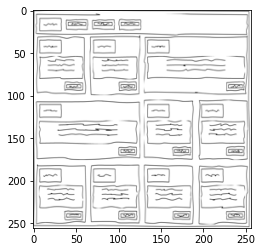

In [ ]:
image_index     = 0
dataset_eval    = S2CDataset(data_folder, 'train', transform=transform)
image           = dataset_eval[image_index][3]
caption         = dataset_eval[image_index][1]
print([index_to_line[str(i)] for i in caption.tolist()])
pred_words      = evaluate_image(image)
print(['<start>'] + pred_words)

In [ ]:
print(len(pred_words))
render_html(pred_words)

1500
< div class = " grid h-full w-full " style = " grid-template-rows : auto 1fr ; " > < div class = " bg-gray-300 h-2 navbar " > < div class = " px-2 text-2xl " > < label class = " font-bold " > [Label] < / label > < / div > < div class = " flex flex-1 px-2 " > < div class = " flex gap-5 " > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < / div > < / div > < / div > < div class = " bg-gray-100 gap-5 grid grid-cols-4 grid-rows-3 h-full p-2 " > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 1 / 2 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 3 / 4 ; " > < label

412it [08:35,  1.25s/it]


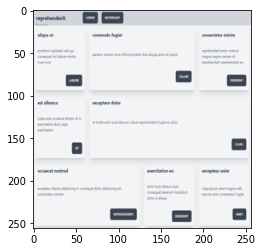

In [ ]:
references = []
predictions = []
dataset_eval    = S2CDataset(data_folder, 'val', transform=transform)

for idx, image_index in tqdm(enumerate(dataset_eval)):
    image           = image_index[3]
    caption         = image_index[1]
    references.append([index_to_line[str(i)] for i in caption.tolist()])
    pred_words      = evaluate_image(image)
    predictions.append(['<start>'] + pred_words)

In [ ]:
p = list(map(lambda x: ' '.join(x), predictions))[:10]
r = list(map(lambda x: ' '.join(x), references))[:10]

In [ ]:
len(r)

412

In [ ]:
rouge   =  evaluate.load("rouge")
bleu    = evaluate.load("bleu")
meteor  =  evaluate.load("meteor")



In [ ]:
def compute_metrics():

    rouge_output = rouge.compute(predictions = p, references = r)['rouge2']
    bleu_output = bleu.compute(predictions =p, references = r)
    meteor_output = meteor.compute(predictions =p, references = r)
    
    return {
        "rouge2"  : round(rouge_output, 4),
        "bleu"     : round(bleu_output['bleu'], 4),
        "meteor"   : round(meteor_output['meteor'], 4),
    }

compute_metrics()

{'rouge2': 0.5039, 'bleu': 0.4324, 'meteor': 0.397}

In [ ]:
def resize_image_tensor(T, size):
    T = T.unsqueeze(0)
    T = torch.nn.functional.interpolate(T,size=size, mode='bilinear')
    T = T.squeeze(0)
    return T

In [ ]:
def visualize_att(image, seq, alphas, rev_word_map,num_row=6,num_col=5,figwidth=20,figheight=15, smooth=False):
    image = resize_image_tensor(image.float(), (14 * 24, 14 * 24)).permute(1,2,0)
    image = image.int()
    words = [rev_word_map[str(ind)] for ind in seq if ind not in [13, 0]]
    f, ax = plt.subplots(num_row,num_col,figsize=(figwidth,figheight))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    for t in range(len(words)):
        if t > 50:
            break
        row = int(t/num_col)
        col = int(t%num_col)

        ax[row,col].text(6, 5, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        ax[row,col].imshow(image)
        if t < len(words) - 2:
          current_alpha = alphas[t, :]
        else:
          current_alpha = alphas[0,:]
        
        if smooth:
            
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy().reshape((14,14)), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy().reshape((14,14)), [14 * 24, 14 * 24])

        if t == 0:
            ax[row,col].imshow(alpha, alpha=0)
        elif t == len(words)-1:
            #print('here here')
            ax[row,col].imshow(alpha, alpha=0)
        else:
            ax[row,col].imshow(alpha, alpha=0.5)
        plt.set_cmap(cm.Greys_r)
        ax[row,col].axis('off')
    plt.tight_layout()

In [ ]:
with torch.no_grad():
    image_index         = 211
    dataset_eval        = S2CDataset(data_folder, 'train', transform=transform)
    real_image          = dataset_eval[image_index][3]
    images              = dataset_eval[image_index][0].unsqueeze(0).to(device)
    encoded_captions    = dataset_eval[image_index][1].unsqueeze(0).to(device)
    caption_lengths     = dataset_eval[image_index][2].unsqueeze(0).to(device)

    encoded_images = encoder(images)
    scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(encoded_images, encoded_captions, caption_lengths)
    visualize_att(real_image,list(caps_sorted.detach().cpu().numpy()[0]),
            alphas.squeeze(0).detach().cpu(),index_to_line,
            num_row=10,num_col=5,figwidth=11,figheight=22)

# Transformers

In [ ]:
!unzip -q /content/drive/MyDrive/ML/Masters/encoded_data.zip

In [ ]:
from IPython.display import clear_output
!pip install lorem-text
!pip install datasets transformers rouge-score
!pip install evaluate
clear_output()

In [ ]:
import torch
import torchvision
import torch.nn                 as nn
import torch.nn.functional      as F
import torch.optim              as optim
import torchvision.transforms   as transforms
import matplotlib.pyplot        as plt
import matplotlib.cm            as cm
import numpy                    as np
import pandas                   as pd
import multiprocessing          as mp

import datasets
import evaluate
import importlib
import skimage
import h5py
import json
import glob
import os
import re

from torch.utils.data           import Dataset
from torch.nn.utils.rnn         import pack_padded_sequence
from torchvision.models         import ResNet101_Weights, resnet101
from imageio                    import imread
from PIL                        import Image
from skimage.transform          import resize
from tqdm                       import tqdm
from collections                import Counter
from random                     import seed, choice, sample
from ast                        import literal_eval
from torch.utils.data           import Dataset, DataLoader, random_split
from transformers               import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers               import VisionEncoderDecoderModel, ViTFeatureExtractor
from transformers               import AutoTokenizer, GPT2Config, default_data_collator
from tokenizers                 import Tokenizer
from tokenizers.models          import WordLevel
from tokenizers.pre_tokenizers  import WhitespaceSplit
from tokenizers                 import pre_tokenizers
from IPython.core.display       import display, HTML
from lorem_text                 import lorem
from html.parser                import HTMLParser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class config : 
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 4
    EPOCHS = 3
    VAL_BATCH_SIZE = 4
    VAL_EPOCHS = 1
    LR = 5e-5

In [ ]:
rouge   =  evaluate.load("rouge")
bleu    = evaluate.load("bleu")
meteor  =  evaluate.load("meteor")

def compute_metrics(pred):
    labels_ids  = pred.label_ids
    pred_ids    = pred.predictions

    pred_str                        = list(map(lambda p: tokenizer.decode(p), pred_ids))
    labels_ids[labels_ids == -100]  = line_to_index['<pad>']
    label_str                       = list(map(lambda l: tokenizer.decode(l), labels_ids))

    rouge_output = rouge.compute(
        predictions = pred_str, 
        references  = label_str)['rouge2']
    
    bleu_output = bleu.compute(
        predictions = pred_str, 
        references  = label_str)
    
    meteor_output = meteor.compute(
        predictions = pred_str, 
        references  = label_str)
    
    return {
        "rouge2"  : round(rouge_output, 4),
        "bleu"     : round(bleu_output['bleu'], 4),
        "meteor"   : round(meteor_output['meteor'], 4),
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# obj = type('',(object,),{"label_ids": torch.randint(1,10, (5,1024)).numpy(), "predictions": torch.randint(1,10, (5,1024)).numpy()})()
# compute_metrics(obj)

In [ ]:
with open('/content/content/data/line_to_index.json', 'r') as j:
    line_to_index = json.load(j)

line_to_index['<unk>']  = len(line_to_index)
tokenizer               = Tokenizer(WordLevel(line_to_index, unk_token='<unk>'))
tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()

In [ ]:
class DecoderDataset(Dataset):
    def __init__(self, data_folder, split, encoder, size = 0, transform = None):

        self.split  = split
        self.h          = h5py.File('{0}/{1}_images.hdf5'.format(data_folder, split), 'r')
        self.imgs       = self.h['images']
        self.encoder    = encoder
        self.transform  = transform

        with open('{0}/{1}_tokens.json'.format(data_folder, split), 'r') as j:
            self.captions = json.load(j)

        self.dataset_size = len(self.captions) if size == 0 else size

    def __getitem__(self, i):
        img_original    = torch.IntTensor(self.imgs[i])
        img             = torch.FloatTensor(self.imgs[i] / 255.)

        if self.transform is not None:
            img = self.transform(img)

        img         = self.encoder(img, return_tensors="pt").pixel_values
        org_caption = self.captions[i][:1024]
        caption     = torch.LongTensor([c if c != line_to_index['<pad>'] else -100 for c in org_caption])
        
        return {"pixel_values": img.squeeze(), "labels": caption, "img_original": img_original, "org_caption": org_caption}

    def __len__(self):
        return self.dataset_size


In [ ]:
data_folder         = '/content/content/data'
transform           = transforms.Compose([
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
feature_extractor   = ViTFeatureExtractor.from_pretrained(config.ENCODER)
train_dataset       = DecoderDataset(data_folder, 'train', feature_extractor, transform = transform)
val_dataset         = DecoderDataset(data_folder, 'val', feature_extractor, transform = transform)
model               = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

model.config.decoder_start_token_id     = line_to_index['<start>']
model.config.pad_token_id               = line_to_index['<pad>']
model.config.eos_token_id               = line_to_index['<end>']
model.config.early_stopping             = True
model.config.length_penalty             = 2.0
model.config.vocab_size                 = len(tokenizer.get_vocab())
model.config.max_length                 = 1024
model.config.num_beams                  = 3
model.config.n_positions                = 1024

clear_output()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir                  = 'VIT_large_gpt2',
    per_device_train_batch_size = config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size  = config.VAL_BATCH_SIZE,
    predict_with_generate       = True,
    evaluation_strategy         = "epoch",
    do_train                    = True,
    do_eval                     = True,
    logging_steps               = 1024,  
    save_strategy               = "no",
    learning_rate               = 5e-5,
    num_train_epochs            = 6,
    overwrite_output_dir        = True,
    save_total_limit            = 1,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3704
  Num Epochs = 6
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5556
  Number of trainable parameters = 239195904
The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: org_caption, img_original. If org_caption, img_original are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Rouge2,Bleu,Meteor
1,No log,0.005740,0.958000,0.948700,0.946400
2,0.037400,0.000943,0.979800,0.968400,0.981400
3,0.003000,0.000127,0.995200,0.992600,0.992800


***** Running Evaluation *****
  Num examples = 412
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: org_caption, img_original. If org_caption, img_original are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
Generate config GenerationConfig {
  "decoder_start_token_id": 53,
  "early_stopping": true,
  "eos_token_id": 54,
  "length_penalty": 2.0,
  "max_length": 1024,
  "num_beams": 3,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn

KeyboardInterrupt: ignored

In [ ]:
model.encoder.save_pretrained("./encoder")
model.decoder.save_pretrained("./decoder")

Configuration saved in ./encoder/config.json
Model weights saved in ./encoder/pytorch_model.bin
Configuration saved in ./decoder/config.json
Configuration saved in ./decoder/generation_config.json
Model weights saved in ./decoder/pytorch_model.bin


In [ ]:
model1 = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("./encoder", "./decoder")

In [ ]:
d = model.generate(train_dataset[0]['pixel_values'].unsqueeze(0).to("cuda"))[0]
# generated_caption = tokenizer.decode(d)
# print(generated_caption)

Generate config GenerationConfig {
  "decoder_start_token_id": 53,
  "early_stopping": true,
  "eos_token_id": 54,
  "length_penalty": 2.0,
  "max_length": 1024,
  "num_beams": 3,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 1024 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
tokenizer.decode(d.cpu().numpy())

'<start> <start> < div class = " grid h-full w-full " style = " grid-template-rows : auto 1fr ; " > < div class = " bg-gray-300 h-2 navbar " > < div class = " px-2 text-2xl " > < label class = " font-bold " > [Label] < / label > < / div > < div class = " flex flex-1 px-2 " > < div class = " flex gap-5 " > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < / div > < / div > < / div > < div class = " bg-gray-100 gap-5 grid grid-cols-4 grid-rows-3 h-full p-2 " > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 1 / 2 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 2 / 3 ;

In [ ]:
def render_html(code):
    body = fix_html(' '.join(code.split()))
    html = """<!DOCTYPE html>
    <html>
    <head>
        <link href="https://cdn.jsdelivr.net/npm/daisyui@2.51.1/dist/full.css" rel="stylesheet" type="text/css" />
        <script src="https://cdn.tailwindcss.com"></script>
    </head>
    <body>
        <div style="height:500px; width:100%" data-theme="light">
            {body}
        </div>
    </body>
    </html>
    """

    body = re.sub('\[Label\]', repl, body)
    body = re.sub('\[Para\]', repl, body)
    display(HTML(fix_html(html.format(body = body))))

In [ ]:
render_html("""< div class = " grid h-full w-full " style = " grid-template-rows : auto 1fr ; " > < div class = " bg-gray-300 h-2 navbar " > < div class = " px-2 text-2xl " > < label class = " font-bold " > [Label] < / label > < / div > < div class = " flex flex-1 px-2 " > < div class = " flex gap-5 " > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < a class = " btn rounded-btn " > [Label] < / a > < / div > < / div > < / div > < div class = " bg-gray-100 gap-5 grid grid-cols-4 grid-rows-3 h-full p-2 " > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 1 / 2 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 2 / 3 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 3 / 5 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 1 / 3 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 3 / 4 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 4 / 5 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 1 / 2 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 2 / 3 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 3 / 4 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < div class = " border border-gray-200 gap-10 grid p-4 rounded shadow-xl undefined " style = " grid-column : 4 / 5 ; " > < label class = " font-bold text-xl " > [Label] < / label > < p class = " " > [Para] < / p > < div class = " flex justify-end " > < button class = " btn " > [Label] < / button > < / div > < / div > < / div > < / div >""")